<a href="https://colab.research.google.com/github/ivan-mihailov/LS-Unit-2-Sprint-2-Assignments/blob/main/Ivan_Mihailov_LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import plot_confusion_matrix

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()
    
    # Set 'id' as the index for the dataframe
    X = X.set_index('id')

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by']
    X = X.drop(columns=unusable_variance)
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    # Create a "missing indicator" column, to account for possibility that 
    # missing values may be predictive
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
        
    return X


In [5]:
# Split train into train & val. Make val the same size as test.
target = 'status_group'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)

In [6]:
# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [7]:
# Make pipeline with FunctionTransformer, Ordinal Encoder, and SimpleImputer
# as transformers and LogisticRegressionCV as estimator

log_pipeline = make_pipeline(
    FunctionTransformer(wrangle, validate=False), 
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    LogisticRegressionCV(cv = 5, random_state = 42, n_jobs = -1)
)

In [8]:
# Fit on train, score on val
log_pipeline.fit(X_train, y_train)
y_pred_val_log = log_pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred_val_log))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Validation Accuracy 0.6098342387519153


In [9]:
print('Model Accuracy for the training data is:', log_pipeline.score(X_train, y_train))

Model Accuracy for the training data is: 0.6057457484125927


In [30]:
# Make pipeline with FunctionTransformer, Ordinal Encoder, and SimpleImputer
# as transformers and RandomForestClassifier as estimator

rf_pipeline = make_pipeline(
    FunctionTransformer(wrangle, validate=False), 
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=172, max_depth = 21, random_state=42, n_jobs=-1)
)

In [31]:
# Fit on train, score on val
rf_pipeline.fit(X_train, y_train)
y_pred_val_rf = rf_pipeline.predict(X_val)
print('Model Accuracy for the training data is:', rf_pipeline.score(X_train, y_train))
print('Validation Accuracy', accuracy_score(y_val, y_pred_val_rf))

Model Accuracy for the training data is: 0.9632121131388481
Validation Accuracy 0.8124390583646748


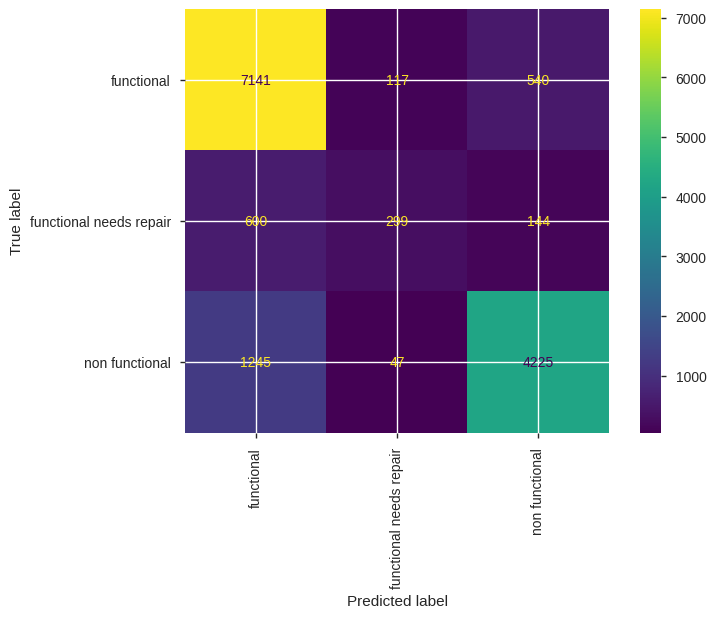

In [32]:
plot_confusion_matrix(rf_pipeline, X_val, y_val, xticks_rotation = 'vertical', values_format = '.0f')

In [33]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred_val_rf))

                         precision    recall  f1-score   support

             functional       0.79      0.92      0.85      7798
functional needs repair       0.65      0.29      0.40      1043
         non functional       0.86      0.77      0.81      5517

               accuracy                           0.81     14358
              macro avg       0.77      0.66      0.69     14358
           weighted avg       0.81      0.81      0.80     14358



In [21]:
y_pred_test = rf_pipeline.predict(X_test) # Predict target vector for the test set
X_test = wrangle(X_test)
submission = pd.DataFrame(data = y_pred_test, index = X_test.index, columns = ['status_group']) # Assign the predicted values to a dataframe
submission.head()

,status_group
id,
50785,non functional
51630,functional
17168,functional
45559,non functional
49871,functional


In [22]:
# Create Kaggle Submission file
submission.to_csv('Ivan_Mihailov_Module4_Kaggle_Submission')

# Stretch Goals IIM

In [41]:
high_card = ['funder', 'installer', 'wpt_name', 'subvillage', 'lga', 'ward', 'scheme_name']

X_train[high_card]

,funder,installer,wpt_name,subvillage,lga,ward,scheme_name
id,,,,,,,
41413,NaN,NaN,Kwa Mwazembe,Itaba,Ileje,Chitete,NaN
48397,Dhv,DWE,Kwamwampwaga,Igima,Kilombero,Mbingu,NaN
6910,Finw,FinW,Pachani,Mnyekehe,Tandahimba,Naputa,Borehole
12526,Adb,DWE,Kwa Mwangayange Mfumbilwa,Ndanula,Njombe,Igongolo,Ibiki gravity water scheme
17511,Dwe,DWE,Kwa Bungwa,Nyakerera,Kasulu,Kitagata,Nyachenda
...,...,...,...,...,...,...,...
14972,No,DWE,Shule Ya Msingi Kasu,Chiminoka,Nkasi,Chala,NaN
7355,Hesawa,DWE,Kwa Matira Kisuka,Mine,Bunda,Kabasa,NaN
2283,African Relie,Af,Chombe,Masogola,Bagamoyo,Yombo,NaN


In [47]:
X_train = X_train.select_dtypes(exclude='number').replace(np.nan, 'none', regex=True)

In [48]:
X_train[high_card]

,funder,installer,wpt_name,subvillage,lga,ward,scheme_name
id,,,,,,,
41413,none,none,Kwa Mwazembe,Itaba,Ileje,Chitete,none
48397,Dhv,DWE,Kwamwampwaga,Igima,Kilombero,Mbingu,none
6910,Finw,FinW,Pachani,Mnyekehe,Tandahimba,Naputa,Borehole
12526,Adb,DWE,Kwa Mwangayange Mfumbilwa,Ndanula,Njombe,Igongolo,Ibiki gravity water scheme
17511,Dwe,DWE,Kwa Bungwa,Nyakerera,Kasulu,Kitagata,Nyachenda
...,...,...,...,...,...,...,...
14972,No,DWE,Shule Ya Msingi Kasu,Chiminoka,Nkasi,Chala,none
7355,Hesawa,DWE,Kwa Matira Kisuka,Mine,Bunda,Kabasa,none
2283,African Relie,Af,Chombe,Masogola,Bagamoyo,Yombo,none


In [81]:
from category_encoders import TargetEncoder
encoder = ce.TargetEncoder(min_samples_leaf = 2, smoothing = 1.2)
X_train_encoded = encoder.fit_transform(X_train, y_train=='functional')

rf_te_pipeline = make_pipeline(
    SimpleImputer(strategy = 'median'),
    RandomForestClassifier(n_estimators=172, max_depth = 21, random_state=42, n_jobs=-1)
)

rf_te_pipeline.fit(X_train_encoded, y_train)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=21, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=172, n_jobs=-1,
                                        oob_score=Fal

In [83]:
X_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45042 entries, 41413 to 28687
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   funder                     44615 non-null  float64
 1   installer                  44569 non-null  float64
 2   wpt_name                   34161 non-null  float64
 3   basin                      45042 non-null  float64
 4   subvillage                 40100 non-null  float64
 5   region                     45042 non-null  float64
 6   lga                        45042 non-null  float64
 7   ward                       45001 non-null  float64
 8   public_meeting             45042 non-null  float64
 9   scheme_management          45042 non-null  float64
 10  scheme_name                44608 non-null  float64
 11  permit                     45042 non-null  float64
 12  extraction_type            45042 non-null  float64
 13  extraction_type_group      45042 non-null 

In [94]:
X_val_encoded = encoder.transform(X_val, y_val=='functional')

In [95]:
X_val_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14358 entries, 36642 to 64188
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   amount_tsh                 14358 non-null  float64
 1   funder                     13439 non-null  float64
 2   gps_height                 9393 non-null   float64
 3   installer                  13295 non-null  float64
 4   longitude                  13917 non-null  float64
 5   latitude                   13917 non-null  float64
 6   wpt_name                   5499 non-null   float64
 7   num_private                14358 non-null  int64  
 8   basin                      14358 non-null  float64
 9   subvillage                 6216 non-null   float64
 10  region                     14358 non-null  float64
 11  region_code                14358 non-null  int64  
 12  district_code              14358 non-null  int64  
 13  lga                        14340 non-null 

In [96]:
print(X_val_encoded.columns)
print(X_train_encoded.columns)

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'water_quality', 'quality_group', 'quantity', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'year_recorded', 'month_recorded', 'day_recorded', 'years',
       'years_MISSING', 'construction_year_MISSING', 'longitude_MISSING',
       'latitude_MISSING', 'gps_height_MISSING', 'population_MISSING'],
      dtype='object')
Index(['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
       'lga', 'ward', 'public_meeting', 'scheme_management', 'scheme_name',
       'permit', 'extraction_ty

In [97]:
X_val_encoded = X_val_encoded.drop(columns=['amount_tsh', 'gps_height', 'longitude',
       'latitude', 'num_private', 'region_code', 'district_code', 'population', 
       'construction_year', 'year_recorded', 'month_recorded', 'day_recorded', 'years',])

In [98]:
X_val_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14358 entries, 36642 to 64188
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   funder                     13439 non-null  float64
 1   installer                  13295 non-null  float64
 2   wpt_name                   5499 non-null   float64
 3   basin                      14358 non-null  float64
 4   subvillage                 6216 non-null   float64
 5   region                     14358 non-null  float64
 6   lga                        14340 non-null  float64
 7   ward                       11874 non-null  float64
 8   public_meeting             14358 non-null  float64
 9   scheme_management          14358 non-null  float64
 10  scheme_name                12312 non-null  float64
 11  permit                     14358 non-null  float64
 12  extraction_type            14357 non-null  float64
 13  extraction_type_group      14358 non-null 

In [99]:
y_pred_val_rf_te = rf_te_pipeline.predict(X_val_encoded)
print('Model Accuracy for the training data is:', rf_te_pipeline.score(X_train_encoded, y_train))
print('Validation Accuracy', accuracy_score(y_val, y_pred_val_rf_te))

Model Accuracy for the training data is: 0.9167221704187203
Validation Accuracy 0.49902493383479596


In [101]:
features = ['gps_height', 'longitude', 'latitude', 'wpt_name', 'subvillage', 
            'ward', 'population', 'construction_year', 'quantity', 
            'waterpoint_type', 'day_recorded', 'years']
train = wrangle(train)
val=wrangle(val)
test= wrangle(test)            
X_train = train[features]
X_val = val[features]
X_test = test[features]

In [105]:
from sklearn.linear_model import LogisticRegression
# Make pipeline with Ordinal Encoder, and SimpleImputer
# as transformers and LogisticRegressionCV as estimator

log_pipeline_12_feat = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    LogisticRegression(random_state = 42, n_jobs = -1)
)

In [106]:
# Fit on train, score on val
log_pipeline_12_feat.fit(X_train, y_train)
y_pred_val_log_12_feat = log_pipeline_12_feat.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred_val_log_12_feat))

Validation Accuracy 0.549937317175094


In [107]:
# Make pipeline with Ordinal Encoder, and SimpleImputer
# as transformers and RandomForestClassifier as estimator

rf_pipeline_12_feat = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=172, max_depth = 21, random_state=42, n_jobs=-1)
)

In [108]:
# Fit on train, score on val
rf_pipeline_12_feat.fit(X_train, y_train)
y_pred_val_rf_12_feat = rf_pipeline_12_feat.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred_val_rf_12_feat))

Validation Accuracy 0.7843014347402145
